### Python version 3.10.6 

## Рекомендательная система по товарам автомобильной тематики Amazon

 Будет использоваться библиотека  Surprise для создания системы рекомендаций к автотоварам, используя набор данных Automotive, </br> доступный по ссылке https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Automotive.csv

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
import random
import datetime
%matplotlib inline

### Для построения рекомендательной системы будет использованы только данные рейтинга 
- itemID - код товара
- reviewerID - код покупателя
- rating - присвоеная оценка товара от 1 до 5
- timestamp - метка времени

In [58]:
import urllib
import ssl
#load dataset from url
ssl._create_default_https_context = ssl._create_unverified_context
url='https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Automotive.csv'
ratings_data = pd.read_csv(url,header=None)
ratings_data.columns=['itemID','reviewerID','rating','timestamp']
ratings_data=ratings_data.sort_values('timestamp').reset_index(drop=True)
#save dataset locally
ratings_data.to_csv('./dataset/Automotive.csv')

ratings_data.head(10)



## EDA

In [60]:
print('Записей с пропущенными значениями:')
print(ratings_data.isnull().sum())
print(f"Уникальных товаров - {ratings_data['itemID'].unique().shape[0]}")
print(f"Уникальных пользователей - {ratings_data['reviewerID'].unique().shape[0]}")
print(f"Всего отзывов - {ratings_data.shape[0]}")


Записей с пропущенными значениями:
itemID        0
reviewerID    0
rating        0
timestamp     0
dtype: int64
Уникальных товаров - 925387
Уникальных пользователей - 3873247
Всего отзывов - 7990165


Text(0.5, 1.0, 'Распределение оценок')

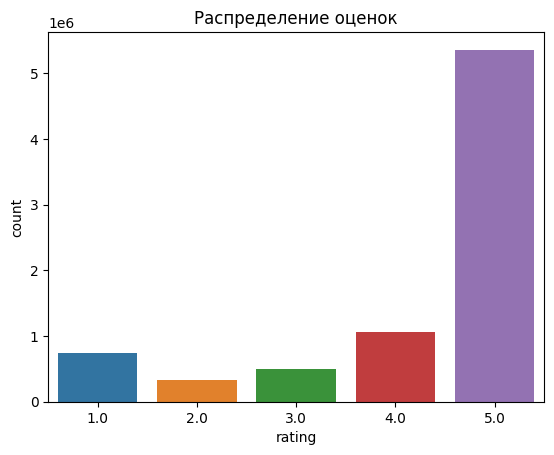

In [4]:
sns.countplot(data=ratings_data,x='rating').set_title("Распределение оценок")


Text(0.5, 1.0, 'Рейтинг по годам')

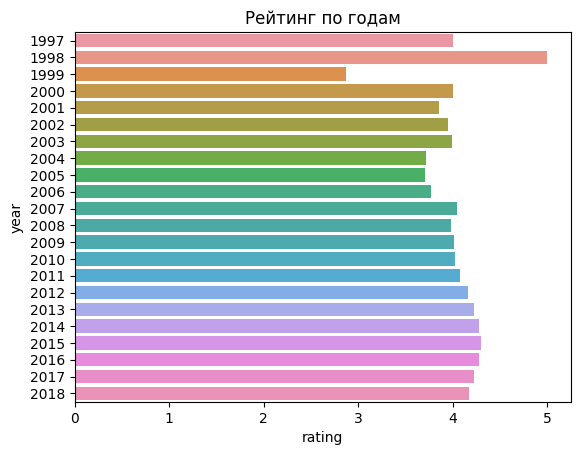

In [5]:
ratings_data['year']=pd.to_datetime(ratings_data['timestamp'], unit='s').dt.year
df=ratings_data.groupby('year').agg({'rating':'mean','timestamp':'count'}).reset_index()
sns.barplot(data=df,y='year',x='rating',orient='h').set_title('Рейтинг по годам')

Text(0, 0.5, 'Год')

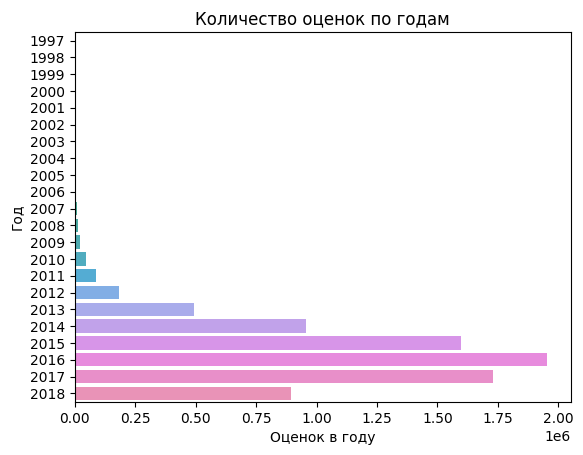

In [7]:
sns.barplot(data=df,y='year',x='timestamp',orient='h').set_title('Количество оценок по годам')
plt.xlabel("Оценок в году")
plt.ylabel("Год")

До 2013 года было незначительное количество оценок, по этому будем считать их устаревшими и не учитывать при построении рекомендательной системы

In [8]:
ratings_data=ratings_data.loc[ratings_data['year']>=2013]

### Dataset object

### Для валидации отберем 20% данных из оценок за 2017,2018 г.

In [9]:
val_df=ratings_data.loc[ratings_data['year'].isin([2017,2018])].sample(frac=0.25)
train_df=ratings_data.loc[~ratings_data.index.isin(val_df.index)]
print (f'Тренировочные данные {train_df.shape[0]}, валидационные данные {val_df.shape[0]}')

Тренировочные данные 6972611, валидационные данные 656245


In [10]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df[['reviewerID', 'itemID', 'rating']], reader)
testset=list(val_df[['reviewerID','itemID','rating']].itertuples(index=False, name=None))

####  для построения рекомендательной системы используем модель SVD  c перекрестной валидацией. 

In [13]:

model = SVD(verbose=True, n_epochs=10)
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2105  1.2115  1.2102  1.2108  0.0006  
MAE (testset)     0.9078  0.9081  0.9078  0.9079  0.0001  
Fit time          63.53   65.76   65.88   65.06   1.08    
Test time         25.48   21.24   21.50   22.74   1.94    


{'test_rmse': array([1.21050543, 1.21152726, 1.2102359 ]),
 'test_mae': array([0.90779754, 0.90806808, 0.90775081]),
 'fit_time': (63.52581429481506, 65.764643907547, 65.8774962425232),
 'test_time': (25.4756600856781, 21.242196559906006, 21.497763872146606)}

In [15]:
from surprise import accuracy
predictions=model.test(testset)
# Расчет  RMSE и MAE
accuracy.rmse(predictions, verbose=True)
accuracy.mae(predictions, verbose=True)

RMSE: 1.2791
MAE:  0.9564


0.9564372875521749

In [15]:
# Обучение на всех данных
trainset= data.build_full_trainset()
model.fit (trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [16]:
predictions=model.test(testset)
# Расчет  RMSE и MAE
accuracy.rmse(predictions, verbose=True)
accuracy.mae(predictions, verbose=True)

RMSE: 1.2647
MAE:  0.9425


0.9425294842524017

## Создание прогнозов рейтинга
Мы обучили SVD-модель, теперь можно использовать ее для прогнозирования рейтинга, который пользователь присвоил бы товару, учитывая идентификатор пользователя (reviewerID) и идентификатор товара (itemID). 

In [47]:

reviewerID,itemID,rating=random.choice(testset)
print(f'reviewerID= {reviewerID},itemID = {itemID},rating={rating}')

reviewerID= A2UY5E2DYX7W8C,itemID = B019PU4T52,rating=3.0


In [49]:
model.predict(uid = reviewerID, iid = itemID)

Prediction(uid='A2UY5E2DYX7W8C', iid='B019PU4T52', r_ui=None, est=3.7585569961182745, details={'was_impossible': False})

Основываясь на приведенных выше выходных данных, мы можем видеть, что модель предсказывала, что этот конкретный пользователь даст товару оценку в три звезды (примерно). Модель напрямую не рекомендует товары, но мы можем использовать эту утилиту прогнозирования рейтинга, чтобы определить, какие товары, скорее всего, понравятся пользователю, что позволяет нам обосновать рекомендацию их пользователю.

In [50]:
# Утилиты для подбора товаров
def predict_review(userID, itemID, model):
    
    """
    Predicts the review (on a scale of 1-5) that a user would assign  
    """
    review_prediction = model.predict(uid=userID, iid=itemID)
    return review_prediction.est

def generate_top_recommendation(userID, model, data, thresh=4,num_top=5):
    
    """
    Generates a num_top recommendation for a user based on a rating threshold. Only
    item with a predicted rating at or above the threshold will be recommended
    """
    
    
    recomendations_list=[]
    for item in data:
        rating = predict_review(userID, item, model)

        if rating >= thresh:
            recomendations_list.append([item,rating])
    top_recomendations=pd.DataFrame(recomendations_list,columns=['itemID','Predicted Rating']).sort_values('Predicted Rating',ascending=False)[:num_top].reset_index(drop=True)       
    return top_recomendations

In [51]:
item_for_recomend=pd.DataFrame(testset)[1].unique()
random_user=random.choice(testset)[0]
top_recomendations=generate_top_recommendation(random_user,model,item_for_recomend,thresh=4,num_top=7)
print(f' Лучшие рекомендации для пользователя {random_user} выбранные из {item_for_recomend.shape[0]} товаров')
top_recomendations

 Лучшие рекомендации для пользователя AVIJ7J7TANGHE выбранные из 211581 товаров


,itemID,Predicted Rating
0,B00J2VULQ6,5.0
1,B000JZSPBM,5.0
2,B000NIEECO,5.0
3,B00QKNQZNM,5.0
4,B010QBCZ1O,5.0
5,B0042HBSYE,5.0
6,B000MV599Y,5.0
